In [1]:
# MLP(Multi-Layer Perceptron) - Fashion MNIST Dataset

# 딥러닝 MLP 아키텍처
# - 학습데이터 -> 입력층>은닉층>ReLU>Dropout>출력층>Softmax -> 손실함수

# 입력층
# - (28,28) 크기를 가지는 2차원 이미지를 784개(28x28)의 길이를 갖는 1차원 벡터로 변환해서 은닉층으로 전달
# 은닉층
# - 일반적으로 1개 이상의 은닉층으로 이루어지며 각각의 은닉층은 내부에 많은 노드(node)로 구성
# - 은닉층 개수과 노드 개수는 학습데이터와 성능을 고려하여 최적의 값을 찾아야 하는 하이퍼 파라미터
# ReLU
# - 활성화함수로서 입력값이 0보다 크면 입력값 그대로 내보내고, 0보다 작으면 0을 출력하는 비선형함수
# Dropout
# - 학습데이터에 대해 과적합(overfitting)을 줄이기 위해 신경망 뉴런을 주어진 확률값에 따라 부분적으로 제거(drop)해주는 함수
# 출력층
# - 출력층 노드 개수는 정답(label) 개수와 같은 10개로 설정
# - 학습데이터의 정답은 0~9까지 총 10개 가운데 하나의 숫자로 표현되기 때문에 출력층 노드 개수가 또한 정답 개수와 동일한 10개
# Softmax
# - 다중 클래스 분류 모델을 만들때 사용
# - 입력된 벡터의 각 요소를 0~1 사이의 확률값으로 변환해주는 함수


In [1]:
# import, GPU 설정
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [2]:
# MNIST Dataset 다운로드
train_dataset = datasets.FashionMNIST(root='.\\data\\FashionMNIST_data',
                               train=True, # train
                               transform=transforms.ToTensor(), # 이미지 픽셀값 0~255까지의 값을 0~1 사이의 값을 변환
                               download=True)

test_dataset = datasets.FashionMNIST(root='.\\data\\FashionMNIST_data',
                               train=False, # test
                               transform=transforms.ToTensor(),
                               download=True)

In [3]:
# 데이터 확인
print(len(train_dataset), len(test_dataset))

60000 10000


In [4]:
# MNIST Dataset 분리(train : validation = 85% : 15%)
train_dataset_size = int(len(train_dataset) * 0.85) # train 85%
validation_dataset_size = int(len(train_dataset) * 0.15) # validation 15%
train_dataset, validation_dataset = random_split(dataset=train_dataset,
                                                 lengths=[train_dataset_size, validation_dataset_size])

In [5]:
# 분리된 데이터 확인
print(len(train_dataset), len(validation_dataset), len(test_dataset))

51000 9000 10000


In [6]:
# batch, Dataloader
BATCH_SIZE = 32

train_dataset_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)

validation_dataset_loader = DataLoader(dataset=validation_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

test_dataset_loader = DataLoader(dataset=test_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


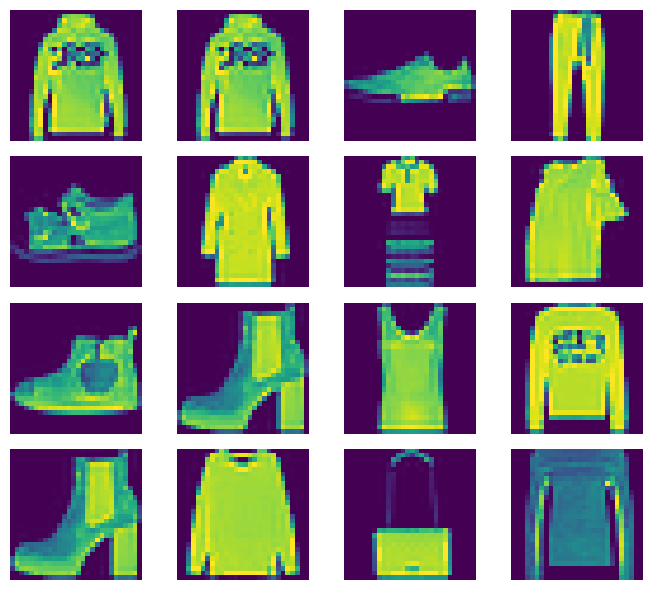

In [7]:
# MNIST Dataset 1개 배치 데이터 확인
images, labels = next(iter(train_dataset_loader))

# labels map 생성
labels_map = { v:k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

plt.figure(figsize=(7,6))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    
    plt.subplot(cols, rows, i)
    plt.imshow(torch.permute(img, (1,2,0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# MLP Model
class MLPDeepLearningModel(nn.Module):
    # model 정의 - 아키텍처를 구성하는 다양한 계층(layer)을 정의
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x) # 입력층
        x = self.fc1(x) # 은닉층
        x = self.relu(x) # 활성화함수 ReLU(비선형함수)
        x = self.dropout(x) # overfitting 방지
        x = self.fc2(x) # 출력층
        return x

In [9]:
# Model 객체 생성
model = MLPDeepLearningModel().to(DEVICE)

# loss function, CrossEntropyLoss 손실함수에는 Softmax 함수 포함되어 있음
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [10]:
# Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
        x_train = images.view(-1, 28 * 28).to(DEVICE)
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()
        train_total += y_train.size(0)
        train_correct += (torch.argmax(outputs, 1) == y_train).sum().item()
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [11]:
# Model evaluate 함수
def model_evaluate(dataloader, model, loss_function, optimizer):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_val = images.view(-1, 28 * 28).to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            # 오차역전파
            # optimizer.zero_grad() # 미분 연산 초기화
            # loss.backward() # 미분 연산
            # optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, 1) == y_val).sum().item()
        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [12]:
# Model test 함수
def model_test(dataloader, model):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_test = images.view(-1, 28 * 28).to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            # 오차역전파
            # optimizer.zero_grad() # 미분 연산 초기화
            # loss.backward() # 미분 연산
            # optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, 1) == y_test).sum().item()
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)

In [14]:
# Model 학습 
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy)
    )

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

epoch :  01 train loss =  0.976525 , train acc =  68.235294 val loss =  0.660460 , val acc =  77.511111
epoch :  02 train loss =  0.624066 , train acc =  78.643137 val loss =  0.560559 , val acc =  80.500000
epoch :  03 train loss =  0.546180 , train acc =  81.456863 val loss =  0.509215 , val acc =  82.233333
epoch :  04 train loss =  0.507808 , train acc =  82.547059 val loss =  0.483466 , val acc =  83.000000
epoch :  05 train loss =  0.477714 , train acc =  83.505882 val loss =  0.458744 , val acc =  83.866667
epoch :  06 train loss =  0.456250 , train acc =  84.137255 val loss =  0.445962 , val acc =  84.177778
epoch :  07 train loss =  0.441564 , train acc =  84.654902 val loss =  0.432823 , val acc =  84.655556
epoch :  08 train loss =  0.427614 , train acc =  85.170588 val loss =  0.418342 , val acc =  85.233333
epoch :  09 train loss =  0.414486 , train acc =  85.494118 val loss =  0.413934 , val acc =  85.311111
epoch :  10 train loss =  0.405363 , train acc =  85.835294 val 

In [15]:
# Test Dataset 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader,
            model=model)

(0.37558493225243145, 86.53)

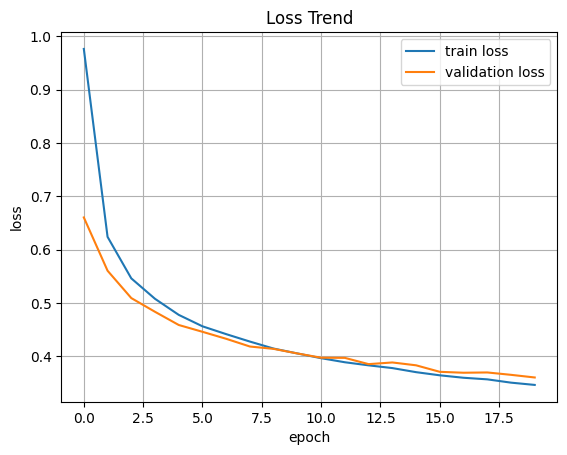

In [16]:
# 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()


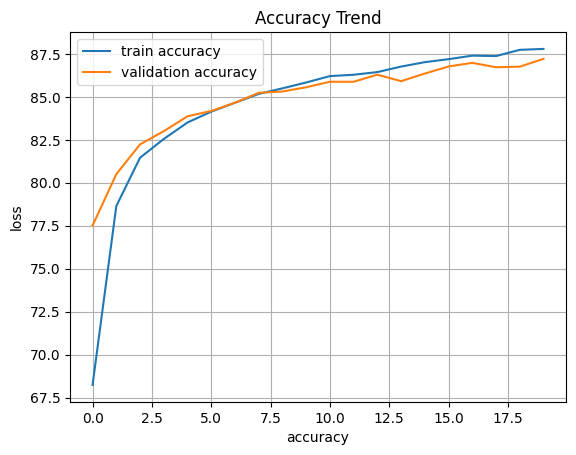

In [17]:
# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('accuracy')
plt.ylabel('loss')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()


In [18]:
# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_mlp_fashion_mnist.ckpt')

In [13]:
# 테스트 - 모델 추론 및 예측값 추출
model = MLPDeepLearningModel().to(DEVICE)
model.load_state_dict(torch.load('.\\models\\model_mlp_fashion_mnist.ckpt'))

BATCH_SIZE = 32

# test dataloader
test_image_loader = DataLoader(dataset=test_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
# test dataset 1개 배치 추출
test_images, test_labels = next(iter(test_image_loader))

# 학습/정답 데이터
x_test = test_images.to(DEVICE)
y_test = test_labels.to(DEVICE)

# 모델 추론
outputs = model(x_test)

# 모델 예측값 추출
_, preds = torch.max(outputs, 1)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


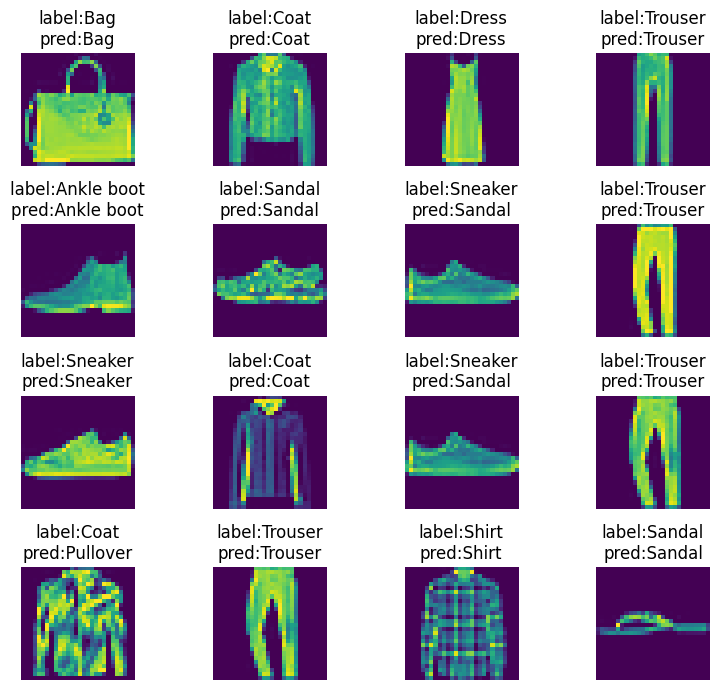

In [19]:
# 시각화 - 추론 및 정답 비교

# labels map 생성 - train_dataset 에서 정답 label map을 생성
labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

# 시각화
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    plt.subplot(rows, cols, i)

    # torch.randint()를 통한 1개의 index 추출
    sample_idx = torch.randint(len(x_test), size=(1,)).item()
    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()

    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred])
    plt.imshow(torch.permute(img, (1, 2, 0))) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()